In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import sklearn.linear_model as lm
import sklearn.ensemble as ens
import sklearn.neural_network as nn

In [2]:
def natural_sort(l):
    def convert(text): return int(text) if text.isdigit() else text.lower()

    def alphanum_key(key): return [convert(c)
                                   for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [4]:
dataset_path = "mtist_datasets"
es_score_path = "mtist_datasets/inference_result_infer_from_did_geom_mean"
n_dset = len([i for i in os.listdir(es_score_path) if i.split("_")[0]=="inferred"])

dataset_files = [i for i in os.listdir(dataset_path) if i.split("_")[0]=="dataset" and int(re.findall("_([0-9]+).csv", i)[0]) < n_dset]
dataset_files = natural_sort(dataset_files)

In [7]:
es_scores = pd.read_csv(f"{es_score_path}/es_scores.csv", index_col=0)
# new_es_scores = pd.read_csv(f"{es_score_path}/new_es_scores.csv", index_col=0)

In [8]:
def samp_scheme_conv(scheme):
    if scheme == "even":
        return 0
    elif scheme == "seq":
        return 1
    else:
        return 2

In [11]:
dset_param_cols = ["n_species", "n_timeseries", "n_timepoints", "noise", "sampling_scheme", "dt"]
dset_param_vals = []

for dset in dataset_files:
    df = pd.read_csv(f"{dataset_path}/{dset}", index_col=0)
    df["sampling_scheme"] = samp_scheme_conv(df["sampling_scheme"][0])
    # df["dt"] = pd.DataFrame(np.diff(df["time"])[np.diff(df["time"])>=0]).mode().values[0,0]
    df["dt"] = np.round(np.median(np.diff(df["time"])[np.diff(df["time"])>=0]), 6)
    dset_param_vals.append(np.unique(df[dset_param_cols], axis=0))

In [13]:
df = pd.DataFrame(np.concatenate(dset_param_vals), columns=dset_param_cols)
df[["es_score_raw", "es_score_floored"]] = es_scores
# df[["new_es_score_raw", "new_es_score_floored"]] = new_es_scores

df

,n_species,n_timeseries,n_timepoints,noise,sampling_scheme,dt,es_score_raw,es_score_floored
0,100.0,10.0,5.0,0.01,0.0,7.575758,0.538721,0.507696
1,100.0,10.0,15.0,0.01,0.0,2.121212,0.504089,0.497595
2,100.0,10.0,5.0,0.01,2.0,3.939394,0.497354,0.503848
3,100.0,10.0,15.0,0.01,2.0,1.212121,0.530544,0.535113
4,100.0,10.0,5.0,0.01,1.0,1.212121,0.525734,0.521886
...,...,...,...,...,...,...,...,...
643,3.0,50.0,15.0,0.10,0.0,2.121212,1.000000,0.833333
644,3.0,50.0,5.0,0.10,2.0,3.939394,0.888889,0.722222
645,3.0,50.0,15.0,0.10,2.0,1.212121,1.000000,0.833333
646,3.0,50.0,5.0,0.10,1.0,1.212121,1.000000,1.000000


In [87]:
n_sp = 10.
df_n_sp = df[df.n_species==n_sp]
# df_n_sp = df_n_sp[df_n_sp["seq_depth"]==1.]
feat = df_n_sp.iloc[:,[1,2,4,5]].values
label = df_n_sp["es_score_raw"].values
# new_label = df_n_sp["new_es_score_raw"].values

In [88]:
lr = lm.LinearRegression()
lr.fit(feat, label)
lr.score(feat, label)

0.7464755145655378

In [89]:
lr.coef_

array([ 0.00130509,  0.00252485, -0.02099274, -0.03572651])

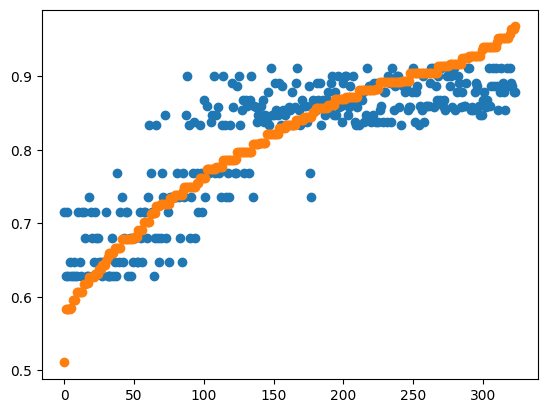

In [96]:
plt.plot(lr.predict(feat)[np.argsort(label)], "o")
plt.plot(label[np.argsort(label)], "o")

0.7880633492410662


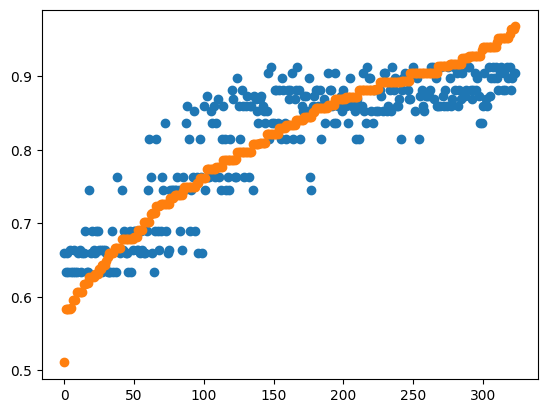

In [149]:
rfr = ens.RandomForestRegressor(100)
rfr.fit(feat, label)
print(rfr.score(feat, label))

plt.plot(rfr.predict(feat)[np.argsort(label)], "o")
plt.plot(label[np.argsort(label)], "o")

0.7881634496105979


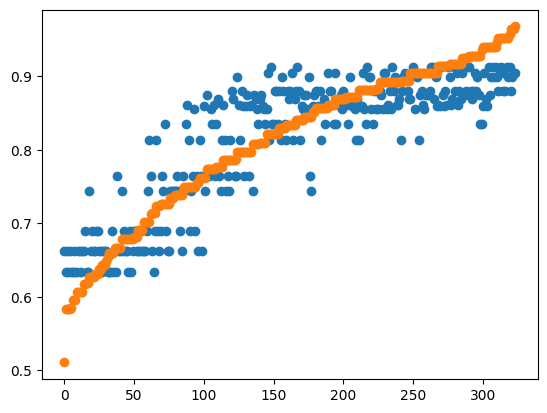

In [150]:
gfr = ens.GradientBoostingRegressor()
gfr.fit(feat, label)
print(gfr.score(feat, label))

plt.plot(gfr.predict(feat)[np.argsort(label)], "o")
plt.plot(label[np.argsort(label)], "o")

---

In [15]:
df["noise"].unique()

array([0.01, 0.1 ])

In [16]:
df["n_timepoints"].unique()

array([ 5., 15.])

In [17]:
df["n_timeseries"].unique()

array([10., 25., 50.])

In [18]:
df["sampling_scheme"].unique()

array([0., 2., 1.])

In [19]:
np.sort(df["dt"].unique())

array([1.212121, 2.121212, 3.939394, 7.575758])

In [21]:
lr.intercept_, lr.coef_

(1.1102230246251565e-16,
 array([-7.48319310e-19,  0.00000000e+00, -9.38071446e-17, -1.44878774e-17,
        -1.42784642e-17,  1.00000000e+00]))

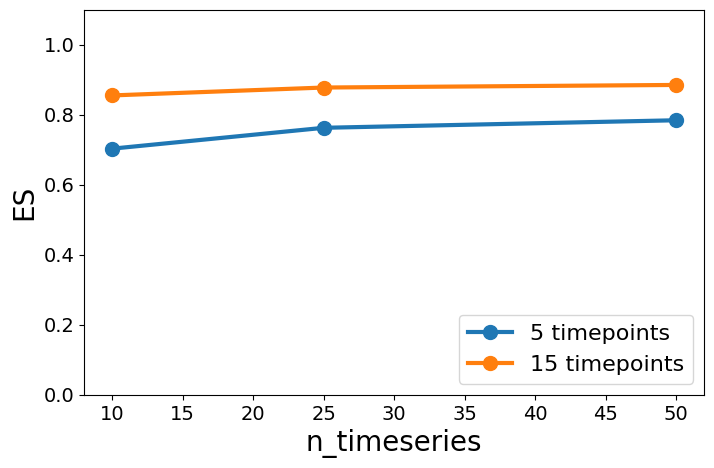

In [151]:
plt.figure(figsize=(8,5))
for j, n_tp in enumerate(df["n_timepoints"].unique()):
    plt.plot([i for i in df["n_timeseries"].unique()], [df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,i]).all(1).values]["es_score_raw"].values.mean() for i in df["n_timeseries"].unique()], c=f"C{j}", marker="o", ms=10, lw=3, label=f"{n_tp:.0f} timepoints")

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("ES", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

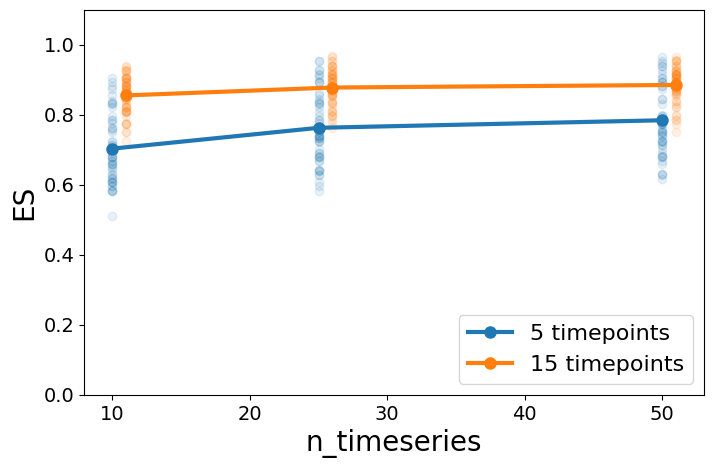

In [108]:
plt.figure(figsize=(8,5))

for i, n_ts in enumerate(df_n_sp["n_timeseries"].unique()):
    for j, n_tp in enumerate(df_n_sp["n_timepoints"].unique()):
        plt.scatter((n_ts+j)*np.ones_like(df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values), df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values, c=f"C{j}", alpha=0.1)

for j, n_tp in enumerate(df["n_timepoints"].unique()):
    plt.plot([i+j for i in df["n_timeseries"].unique()], [df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,i]).all(1).values]["es_score_raw"].values.mean() for i in df["n_timeseries"].unique()], c=f"C{j}", marker="o", ms=8, lw=3, label=f"{n_tp:.0f} timepoints")

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("ES", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [161]:
df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values

array([0.91666667, 0.95238095, 0.94047619, 0.89285714, 0.86904762,
       0.9047619 , 0.91489362, 0.89361702, 0.90425532, 0.87234043,
       0.92553191, 0.91489362, 0.91489362, 0.88297872, 0.95744681,
       0.87234043, 0.86170213, 0.91489362, 0.86170213, 0.84042553,
       0.92553191, 0.79787234, 0.82978723, 0.84042553, 0.86904762,
       0.82142857, 0.89285714, 0.77380952, 0.78571429, 0.82142857,
       0.89285714, 0.88095238, 0.94047619, 0.79761905, 0.85714286,
       0.9047619 , 0.91666667, 0.92857143, 0.95238095, 0.89285714,
       0.91666667, 0.92857143, 0.9047619 , 0.96428571, 0.94047619,
       0.86904762, 0.89285714, 0.88095238, 0.78571429, 0.9047619 ,
       0.95238095, 0.75      , 0.85714286, 0.91666667])

In [175]:
[i+j for i in df["n_timepoints"].unique()]

[5.0, 15.0]

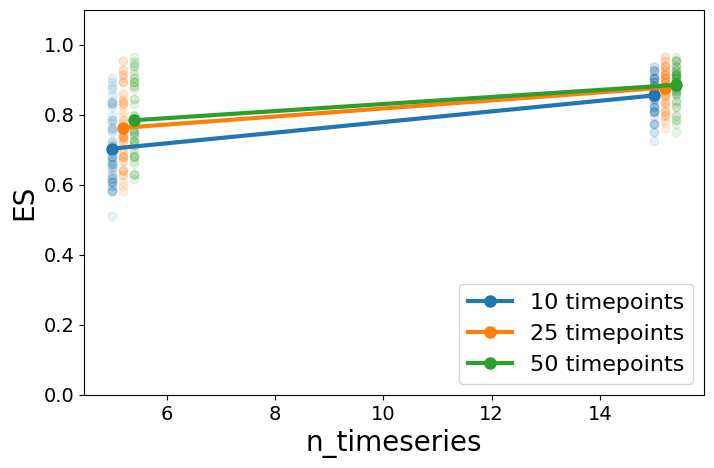

In [181]:
plt.figure(figsize=(8,5))

for j, n_tp in enumerate(df_n_sp["n_timepoints"].unique()):
    for i, n_ts in enumerate(df_n_sp["n_timeseries"].unique()):
        plt.scatter((n_tp+i/5)*np.ones_like(df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values), df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values, c=f"C{i}", alpha=0.1)

for j, n_tp in enumerate(df["n_timeseries"].unique()):
    plt.plot([i+j/5 for i in df["n_timepoints"].unique()], [df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[i,n_tp]).all(1).values]["es_score_raw"].values.mean() for i in df["n_timepoints"].unique()], c=f"C{j}", marker="o", ms=8, lw=3, label=f"{n_tp:.0f} timepoints")

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("ES", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [26]:
df["sampling_scheme"].unique()

array([0., 2., 1.])

In [109]:
samp_schem = ["even", "random", "seq"]

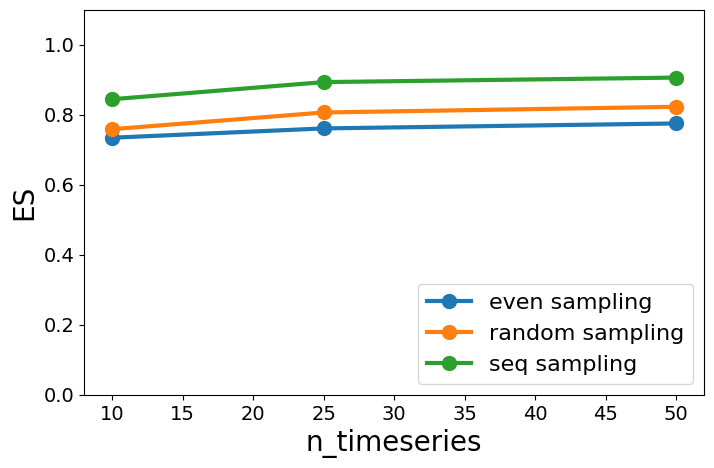

In [111]:
plt.figure(figsize=(8,5))

for i, n_ts in enumerate(df["n_timeseries"].unique()):
    for j, n_tp in enumerate(df["sampling_scheme"].unique()):
        plt.scatter(n_ts, df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values.mean(), c=f"C{j}")

for j, n_tp in enumerate(df["sampling_scheme"].unique()):
    plt.plot([i for i in df["n_timeseries"].unique()], [df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries"]]==[n_tp,i]).all(1).values]["es_score_raw"].values.mean() for i in df["n_timeseries"].unique()], c=f"C{j}", marker="o", ms=10, lw=3, label=f"{samp_schem[j]} sampling")

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("ES", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

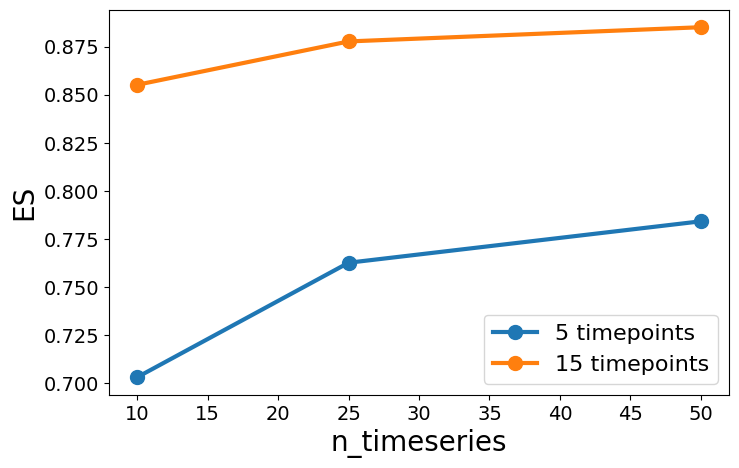

In [210]:
plt.figure(figsize=(8,5))

for j, n_tp in enumerate(df["n_timepoints"].unique()):
    plt.plot([i for i in df["n_timeseries"].unique()], [df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,i]).all(1).values]["es_score_raw"].values.mean() for i in df["n_timeseries"].unique()], c=f"C{j}", marker="o", ms=10, lw=3, label=f"{n_tp:.0f} timepoints")

# plt.ylim(0, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("ES", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [30]:
df["n_timepoints"].unique()

array([ 5., 15.])

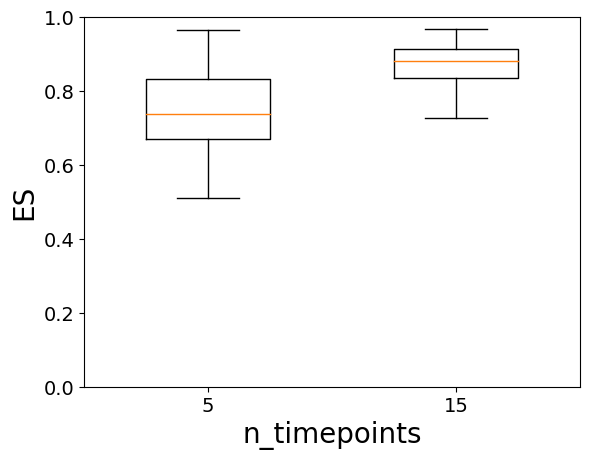

In [137]:
for i, n_ts in enumerate(df["n_timepoints"].unique()):
    plt.boxplot(df_n_sp[(df_n_sp[["n_timepoints"]]==[n_ts]).all(1).values]["es_score_raw"].values, positions=[i], widths=0.5)

plt.xticks(np.arange(len(df["n_timepoints"].unique())), labels=df["n_timepoints"].unique().astype(int))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timepoints", fontsize=20)
plt.ylabel("ES", fontsize=20)
plt.ylim(0, 1)
plt.show()

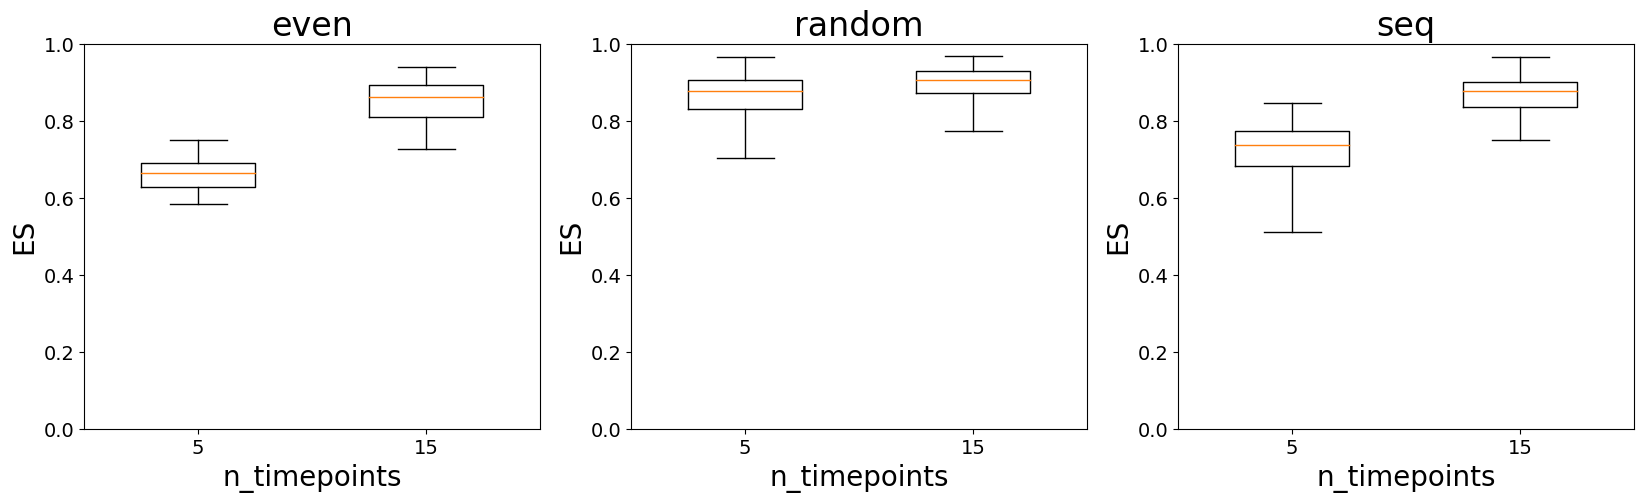

In [200]:
plt.subplots(1, 3, figsize=(20,5))
for j in range(3):
    plt.subplot(1, 3, j+1)
    for i, n_ts in enumerate(df["n_timepoints"].unique()):
        plt.boxplot(df_n_sp[(df_n_sp[["sampling_scheme", "n_timepoints"]]==[j,n_ts]).all(1).values]["es_score_raw"].values, positions=[i], 
                    whis=(0, 100), widths=0.5)

    plt.xticks(np.arange(len(df["n_timepoints"].unique())), labels=df["n_timepoints"].unique().astype(int))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("n_timepoints", fontsize=20)
    plt.ylabel("ES", fontsize=20)
    plt.ylim(0, 1)
    plt.title(samp_schem[j], fontsize=24)
plt.show()

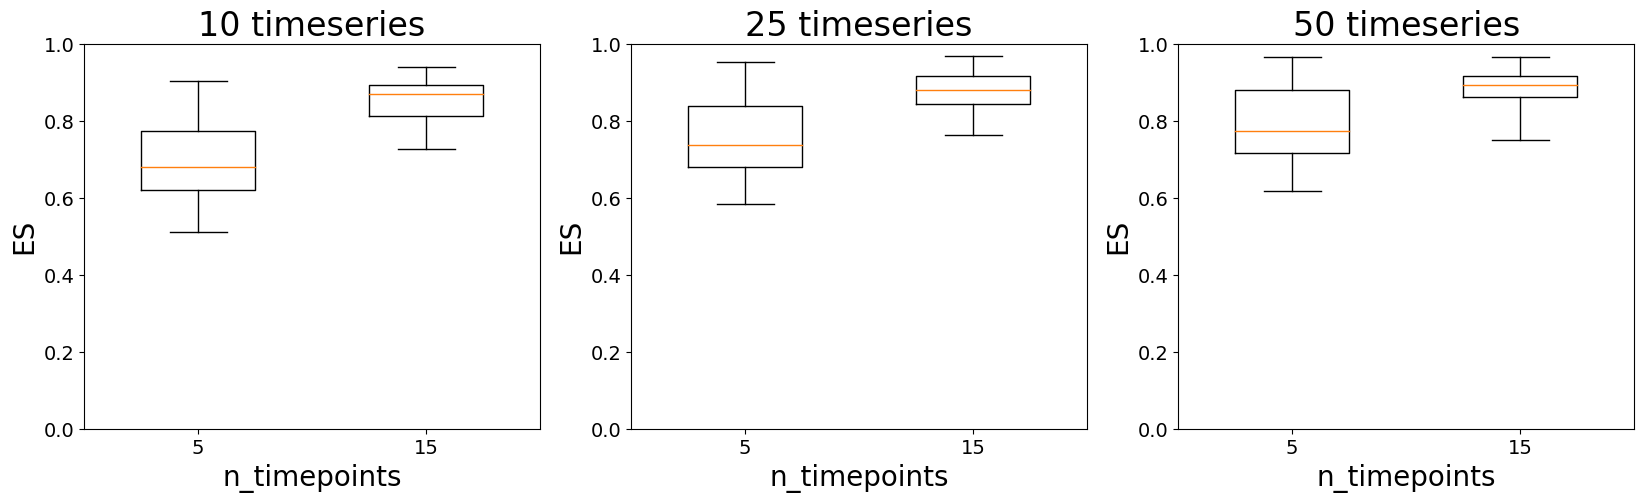

In [199]:
plt.subplots(1, 3, figsize=(20,5))
for j, n_ts in enumerate(df_n_sp["n_timeseries"].unique()):
    plt.subplot(1, 3, j+1)
    for i, n_tp in enumerate(df["n_timepoints"].unique()):
        plt.boxplot(df_n_sp[(df_n_sp[["n_timeseries", "n_timepoints"]]==[n_ts,n_tp]).all(1).values]["es_score_raw"].values, positions=[i], 
                    whis=(0, 100), widths=0.5)

    plt.xticks(np.arange(len(df["n_timepoints"].unique())), labels=df["n_timepoints"].unique().astype(int))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("n_timepoints", fontsize=20)
    plt.ylabel("ES", fontsize=20)
    plt.ylim(0, 1)
    plt.title(f"{n_ts:.0f} timeseries", fontsize=24)
plt.show()

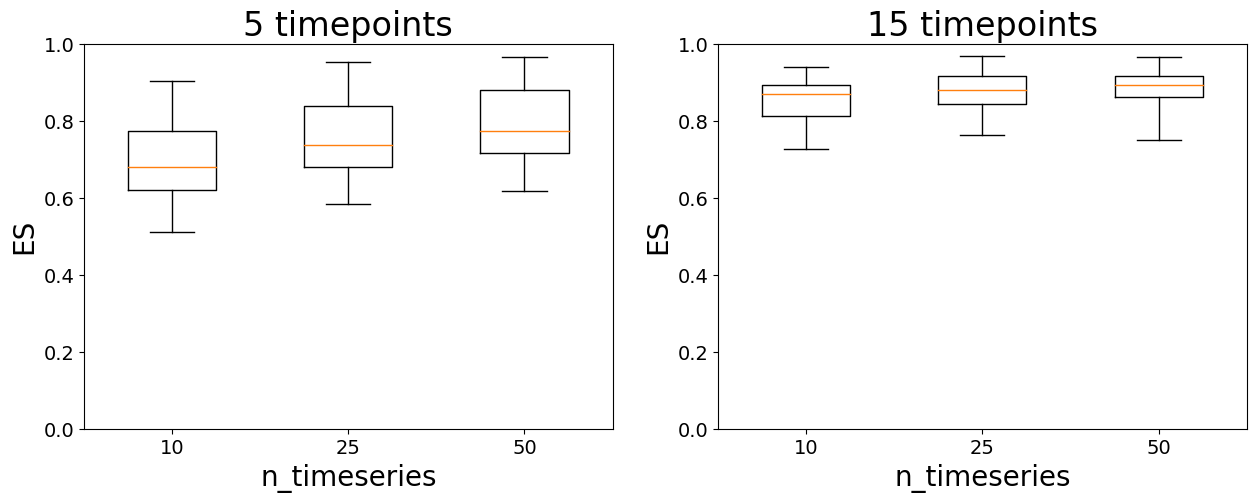

In [198]:
plt.subplots(1, 2, figsize=(15,5))
for j, n_tp in enumerate(df_n_sp["n_timepoints"].unique()):
    plt.subplot(1, 2, j+1)
    for i, n_ts in enumerate(df["n_timeseries"].unique()):
        plt.boxplot(df_n_sp[(df_n_sp[["n_timeseries", "n_timepoints"]]==[n_ts,n_tp]).all(1).values]["es_score_raw"].values, positions=[i], 
                    whis=(0, 100), widths=0.5)

    plt.xticks(np.arange(len(df["n_timeseries"].unique())), labels=df["n_timeseries"].unique().astype(int))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("n_timeseries", fontsize=20)
    plt.ylabel("ES", fontsize=20)
    plt.ylim(0, 1)
    plt.title(f"{n_tp:.0f} timepoints", fontsize=24)
plt.show()

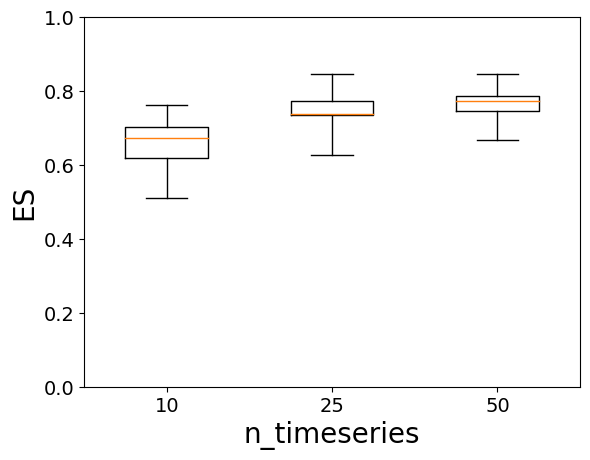

In [135]:
for i, n_ts in enumerate(df["n_timeseries"].unique()):
    plt.boxplot(df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries", "n_timepoints"]]==[2,n_ts,5]).all(1).values]["es_score_raw"].values, positions=[i],
                whis=(0, 100), widths=0.5)

plt.xticks(np.arange(len(df["n_timeseries"].unique())), labels=df["n_timeseries"].unique().astype(int))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("ES", fontsize=20)
plt.ylim(0, 1)
plt.show()

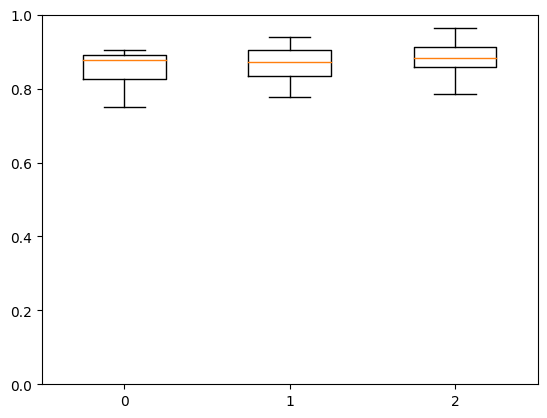

In [33]:
for i, n_ts in enumerate(df["n_timeseries"].unique()):
    plt.boxplot(df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries", "n_timepoints"]]==[2,n_ts,15]).all(1).values]["es_score_raw"].values, positions=[i], widths=0.5)

plt.xticks(np.arange(len(df["n_timeseries"].unique())), labels=df["n_timeseries"].unique().astype(int))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("ES", fontsize=20)
plt.ylim(0, 1)
plt.show()

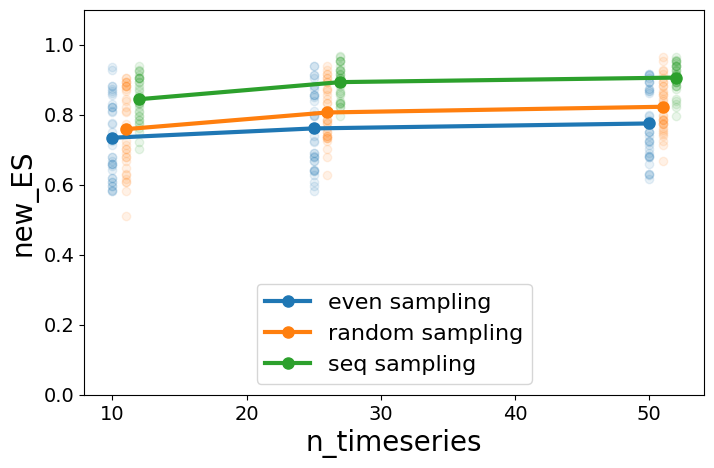

In [35]:
plt.figure(figsize=(8,5))

for i, n_ts in enumerate(df["n_timeseries"].unique()):
    for j, n_tp in enumerate(df["sampling_scheme"].unique()):
        plt.scatter((n_ts+j)*np.ones_like(df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values), df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values, c=f"C{j}", alpha=0.1)
        
for j, n_tp in enumerate(df["sampling_scheme"].unique()):
    plt.plot([i+j for i in df["n_timeseries"].unique()], [df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries"]]==[n_tp,i]).all(1).values]["es_score_raw"].values.mean() for i in df["n_timeseries"].unique()], c=f"C{j}", marker="o", ms=8, lw=3, label=f"{samp_schem[j]} sampling")

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("new_ES", fontsize=20)
plt.legend(loc="lower center", fontsize=16)
plt.show()

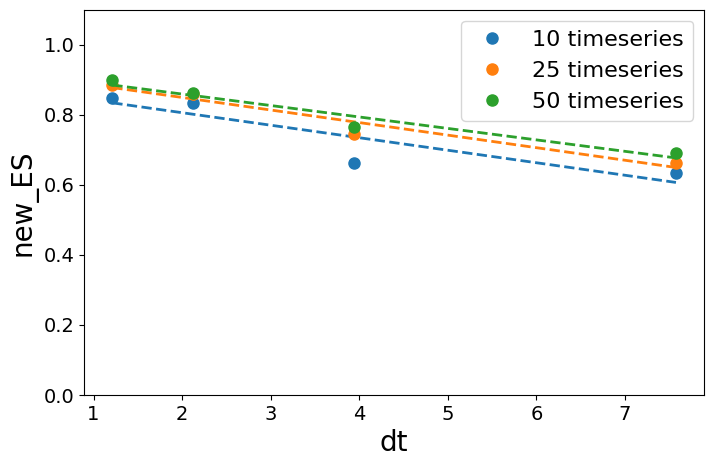

In [38]:
new_es_vs_dt = np.zeros((len(df_n_sp["n_timeseries"].unique()), len(df_n_sp["dt"].unique())))

for i, n_ts in enumerate(df_n_sp["n_timeseries"].unique()):
    for j, n_tp in enumerate(df_n_sp[df_n_sp["n_timeseries"]==n_ts]["dt"].unique()):
        new_es_vs_dt[i,j] = df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values.mean()

plt.figure(figsize=(8,5))
        
for i in range(new_es_vs_dt.shape[0]):
    new_es_vs_dt[i] = new_es_vs_dt[i][np.argsort(df_n_sp["dt"].unique())]
    lr = lm.LinearRegression()
    lr.fit(df_n_sp["dt"].unique()[np.argsort(df_n_sp["dt"].unique())].reshape((-1,1)), new_es_vs_dt[i])
    plt.plot(df_n_sp["dt"].unique()[np.argsort(df_n_sp["dt"].unique())], new_es_vs_dt[i], "o", c=f"C{i}", ms=8, label=f"{df_n_sp['n_timeseries'].unique()[i]:.0f} timeseries")
    plt.plot(df_n_sp["dt"].unique()[np.argsort(df_n_sp["dt"].unique())], lr.predict(df_n_sp["dt"].unique()[np.argsort(df_n_sp["dt"].unique())].reshape((-1,1))), c=f"C{i}", ls="--", lw=2)
    
plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("dt", fontsize=20)
plt.ylabel("new_ES", fontsize=20)
plt.legend(loc="upper right", fontsize=16)
plt.show()

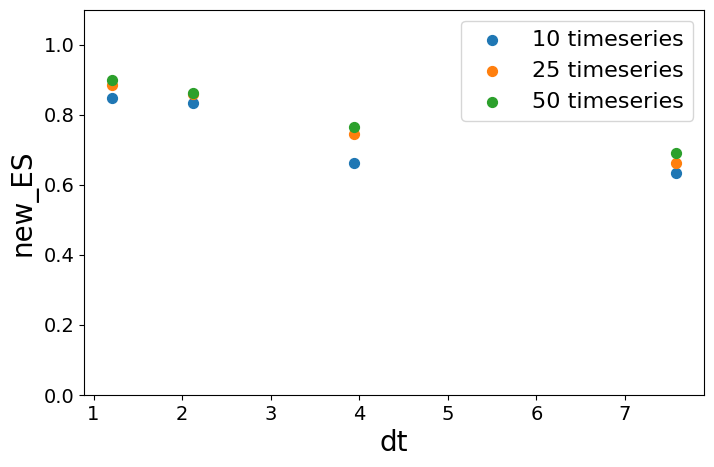

In [40]:
plt.figure(figsize=(8,5))

for i, n_ts in enumerate(df_n_sp["n_timeseries"].unique()):
    for j, n_tp in enumerate(df_n_sp[df_n_sp["n_timeseries"]==n_ts]["dt"].unique()):
        if j == 0:
            plt.scatter(n_tp, df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values.mean(), c=f"C{i}", s=50, label=f"{n_ts:.0f} timeseries")
        else:
            plt.scatter(n_tp, df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values.mean(), c=f"C{i}", s=50)

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("dt", fontsize=20)
plt.ylabel("new_ES", fontsize=20)
plt.legend(loc="upper right", fontsize=16)
plt.show()

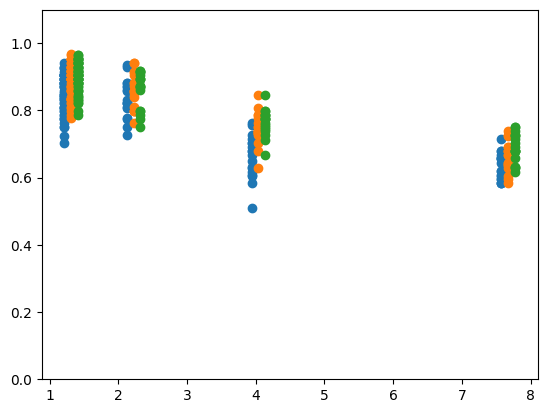

In [42]:
for i, n_ts in enumerate(df["n_timeseries"].unique()):
    for j, n_tp in enumerate(df[df["n_timeseries"]==n_ts]["dt"].unique()):
        plt.scatter((n_tp+i*0.1)*np.ones_like(df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values), df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values, c=f"C{i}")
        
plt.ylim(0, 1.1)
# plt.xscale("log")
plt.show()